# Linear regression (d2l)

* 修改自 d2l 的 3.1 ~ 3.3 (線性回歸從0開始實現、線性回歸的簡潔實現）([link](https://zh.d2l.ai/chapter_linear-networks/linear-regression-scratch.html))
* 這一章，我們要:
  * 先 靠自己刻出 linear regression (from scratch)
  * 再用 pytorch 內建 NN 來做做看. 
  * 比較 自己寫的 和 內建 的差異

In [20]:
%matplotlib inline
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
# from d2l import torch as d2l

## 生 data

* linear model 定義為： $\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$
* 其中， y 是 n 維向量，w 是 p 維向量 (feature維度)，X 是 nxp 矩陣，b 是 scalar
* 先寫一個 function 來產生模擬資料：

In [21]:
def synthetic_data(w, b, num_examples):  #@save
    p = len(w) # feature 個數
    X = torch.normal(0, 1, (num_examples, p)) # 生出 shape = (n, p) 的 matrix
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

* 現在來產出模擬資料：  
  * n = 1000, p = 2
  * w = [2, -3.4], b = 4.2

In [22]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [23]:
features

tensor([[-0.8164, -0.9453],
        [-1.2195,  0.1272],
        [ 0.5601,  1.0297],
        ...,
        [ 0.6262, -1.1752],
        [ 0.6752, -1.0719],
        [ 0.6124,  0.5205]])

In [24]:
labels[:5]

tensor([[5.8100],
        [1.3357],
        [1.8175],
        [5.5317],
        [4.9031]])

* 畫一下 y 對 x1, y 對 x2 的 scatter plot

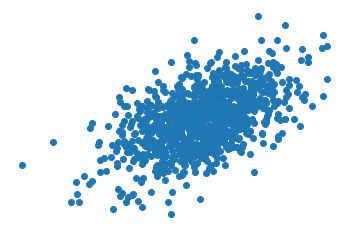

In [25]:
plt.scatter(features[:, 0].detach().numpy(), labels.detach().numpy());
plt.axis("off");

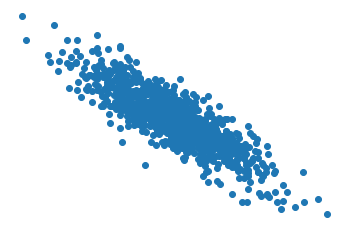

In [26]:
plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy());
plt.axis("off");

## from scratch

### data iter

* 我們要來做出一個 iterator，在讀資料時，每次都可以吐 batch size 的資料出來  
* 這邊複習一下 `range(0, 10, 3)` 的意思，是 0~10，每 3 個取一個，所以結果會是： [0, 3, 6, 9]，最後一個分不完就不取了

In [27]:
def my_data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples)) # [0,1,...,n]
    random.shuffle(indices) # [4,1,25,0,...]
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

* 驗證一下，如果 batch size = 10，看一下第一個 batch 的長相

In [28]:
batch_size = 10
custom_data_iter = my_data_iter(10, features, labels)

for X, y in custom_data_iter:
    print(X, '\n', y)
    break

tensor([[ 0.0324, -0.3804],
        [-0.2023,  0.1426],
        [ 0.0364,  1.5655],
        [-1.3299, -0.7282],
        [-0.1377, -0.3729],
        [ 1.6993,  0.4536],
        [-0.4657, -1.1417],
        [-1.0266, -0.1638],
        [-0.3879,  1.4113],
        [ 0.2974,  0.6664]]) 
 tensor([[ 5.5652],
        [ 3.3013],
        [-1.0554],
        [ 4.0234],
        [ 5.1900],
        [ 6.0698],
        [ 7.1442],
        [ 2.7238],
        [-1.3799],
        [ 2.5420]])


### 定義模型

In [100]:
def model(X, w, b):  #@save
    """ linear regression """
    return torch.matmul(X, w) + b

### loss function

In [102]:
class MyMSE:
    def __init__(self, reduction = "mean"):
        self.reduction = reduction
    def __call__(self, y_hat, y):
        loss = (y_hat - y.reshape(y_hat.shape)) ** 2
        if self.reduction == "mean":
            cost = loss.mean()
        if self.reduction == "sum":
            cost = loss.sum()
        if self.reduction == "none":
            cost = loss
        return cost

# instance
loss = MyMSE(reduction = "mean")

### optimizer

In [103]:
def optimizer(params, lr = 0.03):  #@save
    """ sgd """
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad

### training

#### 走一個 batch 來看看發生什麼事

In [104]:
# hyper-parameters
lr = 0.03

In [112]:
# data
custom_data_iter = my_data_iter(10, features, labels)
X, y = next(iter(custom_data_iter))
print(X)
print(y)

tensor([[-1.6985,  0.0291],
        [-0.0222,  0.0066],
        [ 1.1131, -1.0533],
        [ 0.7180,  0.5768],
        [ 0.0799, -0.5924],
        [ 0.1805,  0.9742],
        [ 0.3105,  1.2170],
        [ 0.3885,  0.6850],
        [ 0.8224, -0.2691],
        [-0.2953, -1.0634]])
tensor([[0.6720],
        [4.1316],
        [9.9998],
        [3.6875],
        [6.3652],
        [1.2642],
        [0.6865],
        [2.6544],
        [6.7504],
        [7.2257]])


In [90]:
# 初始化參數
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

* 看一下初始化的參數，和真值的差距

In [91]:
print(f"estimate w: {w}")
print(f"true w: {true_w}")
print(f"mse of parameter estimation: {((w.reshape(-1)-true_w)**2).sum()}")

estimate w: tensor([[-0.0079],
        [-0.0013]], requires_grad=True)
true w: tensor([ 2.0000, -3.4000])
mse of parameter estimation: 15.583215713500977


In [92]:
print(f"estimate b: {b}")
print(f"true b: {true_b}")
print(f"mse of parameter estimation: {((b.item()-true_b)**2)}")

estimate b: tensor([0.], requires_grad=True)
true b: 4.2
mse of parameter estimation: 17.64


* 可以看到，差距蠻遠的。
* 每個參數，都有他目前對應的 gradient，可以這樣看：

In [93]:
print(w.grad)
print(b.grad)

None
None


* 可以看到，目前 w, b 都沒有 gradient  
* 接著，來做第一次 forward

In [94]:
y_hat = model(X, w, b)
batch_cost = loss(y_hat, y)
print(batch_cost)

tensor(25.1611, grad_fn=<MeanBackward0>)


* 可以看到，起始的 cost 還蠻高，mse 到 25.  
* 接著，我們做 backward：  
  * 取得 gradient. 
  * 利用 gradient，來更新參數

In [95]:
batch_cost.backward()
print(w.grad)
print(b.grad)

tensor([[-2.3259],
        [ 5.6211]])
tensor([-6.3185])


* 可以看到，對 cost 做 backward 後，他自動找到要算 gradient 的對象 (w, b)，並且，把對應的 gradient 塞進去  
* 然後，可以用我們寫好的 sgd，來更新參數

In [96]:
optimizer([w, b], lr = 0.03)

In [97]:
print(f"estimate w: {w}")
print(f"true w: {true_w}")
print(f"mse of parameter estimation: {((w.reshape(-1)-true_w)**2).sum()}")

estimate w: tensor([[ 0.0619],
        [-0.1699]], requires_grad=True)
true w: tensor([ 2.0000, -3.4000])
mse of parameter estimation: 14.190025329589844


In [98]:
print(f"estimate b: {b}")
print(f"true b: {true_b}")
print(f"mse of parameter estimation: {((b.item()-true_b)**2)}")

estimate b: tensor([0.1896], requires_grad=True)
true b: 4.2
mse of parameter estimation: 16.083666673612385


* 可以看到，經過一個 batch，w 和 b 的參數估計，都更接近真值了

* 最後，這邊要注意一下：  
  * 每次做完參數更新後，都會把參數對應的 gradient 歸 0。  
  * 做法是： `w.grad.zero_()` or `b.grad.zero_()`. 
  * 要這麼做的原因是，當我們做 `my_cost.backward()` 時，他背後做的事情是：  
    * 先依據目前的 cost，算出每個 trainiable variable 的 gradient. 
    * 把這個 gradient，"累加" 到目前 trainable variable 的 gradient 上. 
  * 所以，如果你不把 trainable variable 的 gradient 歸 0，那新的 gradient 變成 新+舊 的 gradient，整個歪掉. 
  * 那 pytorch 慣例的寫法，不是在更新完 weight 後，清空 gradient。而是在算 backward 前，清空 gradient. 
  * 雖然看起來這兩種做法，看似等價，但如果你是依據現有的 model weight 延續做 retrain 的話，那你就不能確認一開始的 gradient 是 0。所以總是先歸0，再做 backward，就變成是 pytorch 的 convention. 
  * 這在等一下的 3 個 epoch 範例就可以看到例子

#### 走 3 個 epoch 看看

In [106]:
# hyper-parameters
lr = 0.03
num_epochs = 3

# 初始化參數
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
params = (w, b)

In [107]:
for epoch in range(num_epochs):
    custom_data_iter = my_data_iter(10, features, labels)
    for X, y in custom_data_iter:
        # forward step
        y_hat = model(X, w, b)
        batch_cost = loss(y_hat, y)
        
        # 清空 gradient
        for param in params:
            if param.grad is not None:
                param.grad.zero_()
        
        # backward step
        batch_cost.backward()
        optimizer([w, b], lr = 0.03)  # 使用参数的梯度更新参數
        
    with torch.no_grad():
        y_hat_all = model(features, w, b)
        epoch_cost = loss(y_hat_all, labels)
        print(f'epoch {epoch +1}, loss {epoch_cost}')
        #print(f'epoch {epoch + 1}, loss {float(epoch_cost):f}')

epoch 1, loss 0.00040435069240629673
epoch 2, loss 0.00010177450167248026
epoch 3, loss 0.00010079665662487969


* 可以看到，參數估計結果，和真值非常接近

In [110]:
print(f"estimate w: {w}")
print(f"true w: {true_w}")
print(f"mse of parameter estimation: {((w.reshape(-1)-true_w)**2).sum()}")

estimate w: tensor([[ 2.0004],
        [-3.3999]], requires_grad=True)
true w: tensor([ 2.0000, -3.4000])
mse of parameter estimation: 1.8516522004574654e-07


In [111]:
print(f"estimate b: {b}")
print(f"true b: {true_b}")
print(f"mse of parameter estimation: {((b.item()-true_b)**2)}")

estimate b: tensor([4.1996], requires_grad=True)
true b: 4.2
mse of parameter estimation: 1.8969775737802604e-07


## 內建 function

### data iter

In [113]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(features, labels)
data_iter = DataLoader(dataset, batch_size = 10, shuffle = True)

* 驗證一下：

In [114]:
for X, y in data_iter:
    print(X, '\n', y)
    break

tensor([[ 0.8684,  1.8096],
        [-0.4814, -0.4445],
        [-0.3560, -1.1624],
        [-1.6850,  0.9945],
        [ 2.2541, -0.8971],
        [-0.5724, -0.4106],
        [-4.1179, -0.5625],
        [-0.4651, -1.3560],
        [-0.3070,  0.7921],
        [ 0.4441, -0.7416]]) 
 tensor([[-0.2113],
        [ 4.7432],
        [ 7.4426],
        [-2.5434],
        [11.7608],
        [ 4.4673],
        [-2.1368],
        [ 7.8829],
        [ 0.8922],
        [ 7.6340]])


### 定義模型

In [115]:
from torch import nn
model = nn.Sequential(
    nn.Linear(2, 1) # input 2, output 1
)

* 我們可以看一下這個模型的架構：

In [132]:
model.state_dict

<bound method Module.state_dict of Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)>

* 可以看到，他只有一層，這一層是 linear 層。
* 所以我們可以取出這一層來看看：

In [133]:
model[0]

Linear(in_features=2, out_features=1, bias=True)

* 取裡面的 weight 和 bias 來看看：

In [134]:
model[0].weight

Parameter containing:
tensor([[ 0.1620, -0.4444]], requires_grad=True)

In [135]:
model[0].bias

Parameter containing:
tensor([-0.5005], requires_grad=True)

* 單純把數值取出來：

In [136]:
model[0].weight.data

tensor([[ 0.1620, -0.4444]])

In [137]:
model[0].bias.data

tensor([-0.5005])

* 一次取全部的參數：

In [138]:
model.parameters()

<generator object Module.parameters at 0x132cbb190>

* 是個 generator，那就用 for 迴圈去看總共有哪些東西：

In [118]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[ 0.1620, -0.4444]], requires_grad=True)
Parameter containing:
tensor([-0.5005], requires_grad=True)


* 發現就是 w 和 b  
* 所以，等等要餵給 optimizer 的參數，就是 `model.parameters()`. 
* 然後，如果想看 w 和 b 的估計狀況，要用 `model[0].weight.data` 和 `model[0].bias.data`. 
* 如果想看 w 和 b 的 gradient，要用 `model[0].weight.grad` 和 `model[0].bias.grad`

* 如果要取得 w 和 b 的數值，那要這麼做：

### loss function

In [116]:
loss = nn.MSELoss()

### optimizer

In [119]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.03)

### training

#### 走一個 batch 看看發生什麼事

In [120]:
# data
X, y = next(iter(data_iter))
print(X)
print(y)

tensor([[-1.7370e+00,  2.2797e+00],
        [-1.3517e+00,  6.1767e-01],
        [-8.5405e-02, -4.3337e-01],
        [-4.4443e-01, -2.2241e-01],
        [ 4.1111e-01, -7.4746e-01],
        [ 1.6160e+00,  2.0642e+00],
        [-2.3694e+00, -4.2574e-01],
        [-1.6769e-03, -1.1355e+00],
        [ 7.4750e-01,  3.2721e-01],
        [ 7.4800e-01,  9.3969e-01]])
tensor([[-7.0367],
        [-0.6083],
        [ 5.5124],
        [ 4.0628],
        [ 7.5595],
        [ 0.3955],
        [ 0.9199],
        [ 8.0442],
        [ 4.5495],
        [ 2.5009]])


* 看一下初始參數和真值的差距

In [140]:
w_est = model[0].weight.data
b_est = model[0].bias.data

In [141]:
print(f"estimate w: {w_est}")
print(f"true w: {true_w}")
print(f"mse of parameter estimation: {((w_est.reshape(-1)-true_w)**2).sum()}")

estimate w: tensor([[ 0.1620, -0.4444]])
true w: tensor([ 2.0000, -3.4000])
mse of parameter estimation: 12.113733291625977


In [142]:
print(f"estimate b: {b_est}")
print(f"true b: {true_b}")
print(f"mse of parameter estimation: {((b_est.item()-true_b)**2)}")

estimate b: tensor([-0.5005])
true b: 4.2
mse of parameter estimation: 22.09457495294072


* 此時，這些參數對應的 gradient 也都還是 None

In [144]:
print(model[0].weight.grad)
print(model[0].bias.grad)

None
None


* 做第一次 forward

In [143]:
y_hat = model(X)
batch_cost = loss(y_hat, y)
print(batch_cost)

tensor(24.7222, grad_fn=<MseLossBackward>)


* backward

In [145]:
batch_cost.backward()

* 此時，gradient 已經算出來了：

In [146]:
print(model[0].weight.grad)
print(model[0].bias.grad)

tensor([[-2.8292,  4.5661]])
tensor([-6.5510])


* 更新參數 by optimizer

In [147]:
optimizer.step()

* 看一下參數更新的狀況，是否和真值更近了一些：

In [148]:
w_est = model[0].weight.data
b_est = model[0].bias.data

In [149]:
print(f"estimate w: {w_est}")
print(f"true w: {true_w}")
print(f"mse of parameter estimation: {((w_est.reshape(-1)-true_w)**2).sum()}")

estimate w: tensor([[ 0.2468, -0.5814]])
true w: tensor([ 2.0000, -3.4000])
mse of parameter estimation: 11.017970085144043


In [150]:
print(f"estimate b: {b_est}")
print(f"true b: {true_b}")
print(f"mse of parameter estimation: {((b_est.item()-true_b)**2)}")

estimate b: tensor([-0.3040])
true b: 4.2
mse of parameter estimation: 20.28563309076185


* 沒錯～ 估計得更好了

#### 走 3 個 epoch 看看

In [151]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        # forward
        y_hat = model(X)
        batch_cost = loss(y_hat ,y)
        
        # 清 gradient
        optimizer.zero_grad()
        
        # backward
        batch_cost.backward()
        optimizer.step()
    
    # training epoch loss
    epoch_cost = loss(model(features), labels)
    print(f'epoch {epoch + 1}, loss {epoch_cost}')

epoch 1, loss 0.000374063674826175
epoch 2, loss 0.00010071097494801506
epoch 3, loss 0.0001010773194138892


* 可以看一下，參數估計結果和真值非常接近

In [152]:
w_est = model[0].weight.data
b_est = model[0].bias.data

In [153]:
print(f"estimate w: {w_est}")
print(f"true w: {true_w}")
print(f"mse of parameter estimation: {((w_est.reshape(-1)-true_w)**2).sum()}")

estimate w: tensor([[ 2.0005, -3.4002]])
true w: tensor([ 2.0000, -3.4000])
mse of parameter estimation: 3.2639093205943936e-07


In [154]:
print(f"estimate b: {b_est}")
print(f"true b: {true_b}")
print(f"mse of parameter estimation: {((b_est.item()-true_b)**2)}")

estimate b: tensor([4.1997])
true b: 4.2
mse of parameter estimation: 1.216326290888321e-07


## 內建 function vs 自己寫的

* 最大的差別，應該是在 data iterator
* 自己寫的 data iterator，他跑完後就沒了，所以寫法必須寫成這樣：  

```python
for epoch in range(num_epochs):
    # 每個 epoch 下，都要再做出一個新的 iterator
    custom_data_iter = my_data_iter(10, features, labels)
    for X, y in custom_data_iter:
        ...
```

* 但如果是用內建 function 的 iterator，那就做一次就好，因為它會自動幫你重新實例化：


```python
dataset = TensorDataset(features, labels)
data_iter = DataLoader(dataset, batch_size = 10, shuffle = True) # 就做這麼一次就好

for epoch in range(num_epochs):
    for X, y in data_iter:
        ...
```